We want to show the Electric, Magnetic, and Pixel Intensity from Swarm B

In [158]:
import numpy as np #Lets handle our imports now for section A
import matplotlib.pyplot as plt
import asilib
import asilib.asi
from datetime import datetime, timedelta
from scipy.optimize import curve_fit
from viresclient import set_token
from viresclient import SwarmRequest
import geopack.geopack as gp

import scienceplots

plt.style.use(['science','no-latex'])


In [159]:
time_array=(datetime(2022,12,19,14,4), datetime(2022,12,19,14,6))

In [160]:
#From documentation link
def requester(sc_collection, measurement, residual, sampling_step=None, **kwargs):
    try:
        request = SwarmRequest()
        request.set_collection(sc_collection)
        if residual == True:
            request.set_products(
                measurements=measurement,
                models=["CHAOS"],
                residuals=True,
                sampling_step=sampling_step,
            )
        else:
            request.set_products(
                measurements=measurement,
                models=["CHAOS"],
                sampling_step=sampling_step,
            )
        data = request.get_between(time_array[0], time_array[1], **kwargs) #sets to get data between the first and last value in the time tuple
        df = data.as_dataframe()
    except:
        df = []
    return df

In [161]:
def arrangement(time, array, shape):  # arranges B into a useable format for use later
    barranged = np.zeros((len(time), shape))
    # Re-arranges into proper (n x 3 ) matricies, ugly but works
    for j in range(len(time)):
        for k in range(shape):
            barranged[j][k] = array[j][k]
    return barranged

In [162]:
def unit_array(array):
    arraysum = np.sum(np.abs(array), axis=1)
    # Normalizes and finds unitary
    array_unit = array / arraysum[:, np.newaxis]  # normalizes
    return array_unit

In [163]:
#Lets do B first
ds = requester( 
    "SW_OPER_MAGB_HR_1B", #Mag B, high resolution, 50Hz B (Magnetic field)
    "B_NEC", #Magnetic field in NEC coordinates
    True, 
    asynchronous=False,
    show_progress=False) #cadence of 10 to match our images, in practice this selects every 10th data point since the resolution is 1 sample a second (sps)
print(ds)
BNEC=ds["B_NEC_res_CHAOS"]
Btime = BNEC.index.to_numpy()
BNEC = arrangement(Btime, ds["B_NEC_res_CHAOS"], 3)




                                   Radius   Longitude  \
Timestamp                                               
2022-12-19 14:04:00.010546923  6872238.82 -118.152192   
2022-12-19 14:04:00.030546904  6872238.96 -118.151988   
2022-12-19 14:04:00.050546885  6872239.10 -118.151784   
2022-12-19 14:04:00.070546865  6872239.25 -118.151579   
2022-12-19 14:04:00.090546846  6872239.39 -118.151375   
...                                   ...         ...   
2022-12-19 14:05:59.902414083  6873210.19 -117.308377   
2022-12-19 14:05:59.922414064  6873210.37 -117.308285   
2022-12-19 14:05:59.942414045  6873210.54 -117.308193   
2022-12-19 14:05:59.962414026  6873210.72 -117.308100   
2022-12-19 14:05:59.982414007  6873210.90 -117.308008   

                                                                 B_NEC_res_CHAOS  \
Timestamp                                                                          
2022-12-19 14:04:00.010546923  [82.78851767348624, -138.16134622453387, 36.38...   
2022-1

C:\Users\1101w\AppData\Local\Temp\ipykernel_19292\2246279540.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  barranged[j][k] = array[j][k]


In [164]:
from scipy.spatial.transform import Rotation as R
import numpy as np

def quaternion_inverse_scipy(q):
    # Ensure q is a numpy array
    q = np.asarray(q)
    
    # Create a Rotation object from the quaternion
    rotation = R.from_quat(q)  # Note: scipy uses [x, y, z, w] format
    
    # Compute the inverse rotation
    inverse_rotation = rotation.inv()
    
    
    return inverse_rotation

In [165]:

def find_closest_indices(times1, times2):
    # Convert to numpy arrays
    times1 = np.array(times1)
    times2 = np.array(times2)
    
    # Compute the differences between each time in times1 and all times in times2
    # Resulting in a 2D array where each row contains the absolute differences for one time in times1
    differences = np.abs(times1[:, None] - times2)
    
    # Find the index of the minimum difference for each time in times1
    closest_indices = np.argmin(differences, axis=1)
    
    return closest_indices

In [183]:
measurements_E = [
        "VsatN",
        "VsatE",
        "VsatC",
        "Evx",
        "Evy",
        "Evz",
        "Vixv",
        "Viy",
        "Viz",
        "Quality_flags",
    ]
ds = requester( 
    "SW_EXPT_EFIB_TCT16", #Mag B, high resolution, 50Hz B (Magnetic field)
    measurements_E, #Magnetic field in NEC coordinates
    True, 
    asynchronous=False,
    show_progress=False) #cadence of 10 to match our images, in practice this selects every 10th data point since the resolution is 1 sample a second (sps)
print(ds)
dsB = requester( 
    'SW_OPER_MAGB_HR_1B', #Mag B, high resolution, 50Hz B (Magnetic field)
    ["q_NEC_CRF"], #Magnetic field in NEC coordinates
    False, 
    asynchronous=False,
    show_progress=False)

latitude, longitude, altitude = dsB['Latitude'].to_numpy(), dsB['Longitude'].to_numpy(),  (dsB["Radius"].to_numpy()-6.371e6)/1e3 #km  # Gets Emphermis data


                                    Evz     Radius   Longitude  Quality_flags  \
Timestamp                                                                       
2022-12-19 14:04:00.006750107  8.471214  6872232.0 -118.103455              4   
2022-12-19 14:04:00.068749905  8.235891  6872232.5 -118.102829              4   
2022-12-19 14:04:00.131750107  8.086688  6872233.0 -118.102180              4   
2022-12-19 14:04:00.193749905  8.649044  6872233.5 -118.101555              4   
2022-12-19 14:04:00.256750107  9.233665  6872233.5 -118.100914              4   
...                                 ...        ...         ...            ...   
2022-12-19 14:05:59.693749905 -1.469386  6873200.0 -117.261467              4   
2022-12-19 14:05:59.756750107 -1.843340  6873200.5 -117.261177              4   
2022-12-19 14:05:59.818749905 -2.056162  6873201.0 -117.260887              4   
2022-12-19 14:05:59.881750107 -2.261700  6873201.5 -117.260597              4   
2022-12-19 14:05:59.94374990

In [184]:
t1 = time_array[0]
t0 = datetime(1970,1,1)
ut = (t1-t0).total_seconds()
lat_sat=np.deg2rad(latitude)
lon_sat=np.deg2rad(longitude)
gp.recalc(ut)
print(altitude)
r, theta= gp.geodgeo(altitude,lat_sat,1) #TODO magically, r is 10km less than if you calculated r manually, is this real

x_gc,y_gc,z_gc = gp.sphcar((r)/6371,theta,lon_sat,1)  #spherical to cartesian
 

x_gsm, y_gsm, z_gsm = gp.geogsm(x_gc,y_gc,z_gc, 1) #cartesian to gsm

x_foot,y_foot,z_foot=np.zeros(len(x_gsm)), np.zeros(len(y_gsm)), np.zeros(len(z_gsm)) #initalize an array


[501.23882 501.23896 501.2391  ... 502.21054 502.21072 502.2109 ]


In [185]:
for index in range(len(x_gsm)):
    x_foot_int, y_foot_int, z_foot_int, xx, _,zz = gp.trace(x_gsm[index], y_gsm[index], z_gsm[index], dir=1,rlim=2, r0=(alt-10+6371)/6371, maxloop=300 ) #traces each set of lat,lon,alt outward
    _, _, _, xx2,yy2,zz2 = gp.trace(x_foot_int, y_foot_int, z_foot_int, dir=-1,rlim=100, r0=(alt-10+6371)/6371, maxloop=1000 )#Traces inward
    def curve_fit_func():
        def cubic(t, a, b, c, d):
            return a*t**3 + b*t**2 + c*t + d
        r = np.linspace(1, 1.5, 100000)

        radius_data=np.sqrt(xx2**2+yy2**2+zz2**2)

        params_x, _ = curve_fit(cubic, radius_data, xx2) #Constructs fits on the traces inward since the spatial resolution produced by geopack is limited.
        params_y, _ = curve_fit(cubic, radius_data, yy2)
        params_z, _ = curve_fit(cubic, radius_data, zz2)

        def x(t):
            return cubic(t, *params_x)

        def y(t):
            return cubic(t, *params_y)

        def z(t):
            return cubic(t, *params_z)
        def radius(t):
            return np.sqrt(x(t)**2 + y(t)**2 + z(t)**2)

        index_closest=np.argmin(np.abs(radius(r)-(alt-10+6371)/6371))

        return x(r[index_closest]),y(r[index_closest]),z(r[index_closest])

    x_foot[index],y_foot[index],z_foot[index] = curve_fit_func()

x_done, y_done, z_done = gp.geogsm(x_foot, y_foot, z_foot, -1)

alt_sat_done, lat_sat_done_B,lon_sat_done = np.zeros(len(x_done)), np.zeros(len(x_done)), np.zeros(len(x_done))
for index in range(len(x_done)):
    
    r_done,theta_done,lon_sat_done[index]= gp.sphcar(x_done[index], y_done[index], z_done[index],-1)

    alt_sat_done[index], lat_sat_done_B[index]= gp.geodgeo(r_done*6371,theta_done,-1) #TODO check if this is right

print(alt_sat_done, 'altitude derived from fit')

if np.any(np.abs(alt_sat_done - alt) > 5):
    raise Exception("One or more values in the footprinting are greater than 5km away from the specified alt. Contact owner for a fix, not your fault")



[110.64125191 110.64090562 110.64055842 ... 108.38770821 108.38730207
 108.38689598] altitude derived from fit


In [186]:
indicies=find_closest_indices(ds.index, dsB.index)
quatnecrf=dsB["q_NEC_CRF"].to_numpy()[indicies]
quaternions = []
Esat=np.array([ds["Evx"] , ds["Evy"], ds["Evz"]]).T
vsat=np.array([ds["Vixv"] , ds["Viy"], ds["Viz"]]).T
Etime = ds.index
ENEC=[]
VNEC=[]
for i in range(len(quatnecrf)):
    inverse_quat = quaternion_inverse_scipy(dsB["q_NEC_CRF"].to_numpy()[indicies][i])
    rot_NEC_V= inverse_quat.apply(Esat[i])
    ENEC.append(rot_NEC_V)

    rot_NEC_V= inverse_quat.apply(vsat[i])
    VNEC.append(rot_NEC_V)

ENEC=np.array(ENEC)
VNEC=np.array(VNEC)


Now for the hard part, the pixel intensity
Since the satellite as seen in figure 1 passes through the arc pretty fast, we should increase the resolution of the pixel intensity by super imposing 

Lets define the imager

In [187]:
latitude, longitude, altitude = ds['Latitude'].to_numpy(), ds['Longitude'].to_numpy(),  (ds["Radius"].to_numpy()-6.371e6)/1e3 #km  # Gets Emphermis data

alt=110

In [188]:
asi=asilib.asi.trex_rgb(location_code='yknf', alt=110, time_range=time_array, colors='r')


In [189]:
t1 = time_array[0]
t0 = datetime(1970,1,1)
ut = (t1-t0).total_seconds()
lat_sat=np.deg2rad(latitude)
lon_sat=np.deg2rad(longitude)
gp.recalc(ut)
print(altitude)
r, theta= gp.geodgeo(altitude,lat_sat,1) #TODO magically, r is 10km less than if you calculated r manually, is this real

x_gc,y_gc,z_gc = gp.sphcar((r)/6371,theta,lon_sat,1)  #spherical to cartesian
 

x_gsm, y_gsm, z_gsm = gp.geogsm(x_gc,y_gc,z_gc, 1) #cartesian to gsm

x_foot,y_foot,z_foot=np.zeros(len(x_gsm)), np.zeros(len(y_gsm)), np.zeros(len(z_gsm)) #initalize an array


[501.232  501.2325 501.233  ... 502.201  502.2015 502.202 ]


In [190]:
for index in range(len(x_gsm)):
    x_foot_int, y_foot_int, z_foot_int, xx, _,zz = gp.trace(x_gsm[index], y_gsm[index], z_gsm[index], dir=1,rlim=2, r0=(alt-10+6371)/6371, maxloop=300 ) #traces each set of lat,lon,alt outward
    _, _, _, xx2,yy2,zz2 = gp.trace(x_foot_int, y_foot_int, z_foot_int, dir=-1,rlim=100, r0=(alt-10+6371)/6371, maxloop=1000 )#Traces inward
    def curve_fit_func():
        def cubic(t, a, b, c, d):
            return a*t**3 + b*t**2 + c*t + d
        r = np.linspace(1, 1.5, 100000)

        radius_data=np.sqrt(xx2**2+yy2**2+zz2**2)

        params_x, _ = curve_fit(cubic, radius_data, xx2) #Constructs fits on the traces inward since the spatial resolution produced by geopack is limited.
        params_y, _ = curve_fit(cubic, radius_data, yy2)
        params_z, _ = curve_fit(cubic, radius_data, zz2)

        def x(t):
            return cubic(t, *params_x)

        def y(t):
            return cubic(t, *params_y)

        def z(t):
            return cubic(t, *params_z)
        def radius(t):
            return np.sqrt(x(t)**2 + y(t)**2 + z(t)**2)

        index_closest=np.argmin(np.abs(radius(r)-(alt-10+6371)/6371))

        return x(r[index_closest]),y(r[index_closest]),z(r[index_closest])

    x_foot[index],y_foot[index],z_foot[index] = curve_fit_func()

x_done, y_done, z_done = gp.geogsm(x_foot, y_foot, z_foot, -1)

alt_sat_done, lat_sat_done_E,lon_sat_done = np.zeros(len(x_done)), np.zeros(len(x_done)), np.zeros(len(x_done))
for index in range(len(x_done)):
    
    r_done,theta_done,lon_sat_done[index]= gp.sphcar(x_done[index], y_done[index], z_done[index],-1)

    alt_sat_done[index], lat_sat_done_E[index]= gp.geodgeo(r_done*6371,theta_done,-1) #TODO check if this is right

print(alt_sat_done, 'altitude derived from fit')

if np.any(np.abs(alt_sat_done - alt) > 5):
    raise Exception("One or more values in the footprinting are greater than 5km away from the specified alt. Contact owner for a fix, not your fault")
print(np.rad2deg(lon_sat_done)-360,np.rad2deg(lat_sat_done_E) , 'lat and lon' )
sat_lla=np.array([np.rad2deg(lat_sat_done_E), np.rad2deg(lon_sat_done)-360, alt_sat_done]).T

conjunction_obj = asilib.Conjunction(asi, (np.array(Etime), sat_lla))

[110.65753726 110.65646476 110.65537568 ... 108.40921165 108.40793149
 108.40667617] altitude derived from fit
[-117.75997735 -117.75932394 -117.75866014 ... -116.88317609 -116.88286015
 -116.88257492] [65.95205044 65.94824744 65.94439018 ... 58.62679445 58.62295159
 58.61918566] lat and lon


In [191]:
#Now lets 

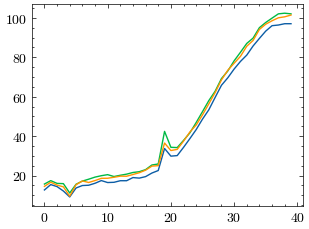

In [192]:
sat_azimuth_elevation, sat_azel_pixels = conjunction_obj.map_azel()
area_intensity = conjunction_obj.intensity(box=(10, 10))
area_mask = conjunction_obj.equal_area(box=(10,10))
# Need to change masked NaNs to 0s so we can plot the rectangular area contours.
area_mask[np.where(np.isnan(area_mask))] = 0
plt.plot(area_intensity) #This gives us a resolution of 3Hz.


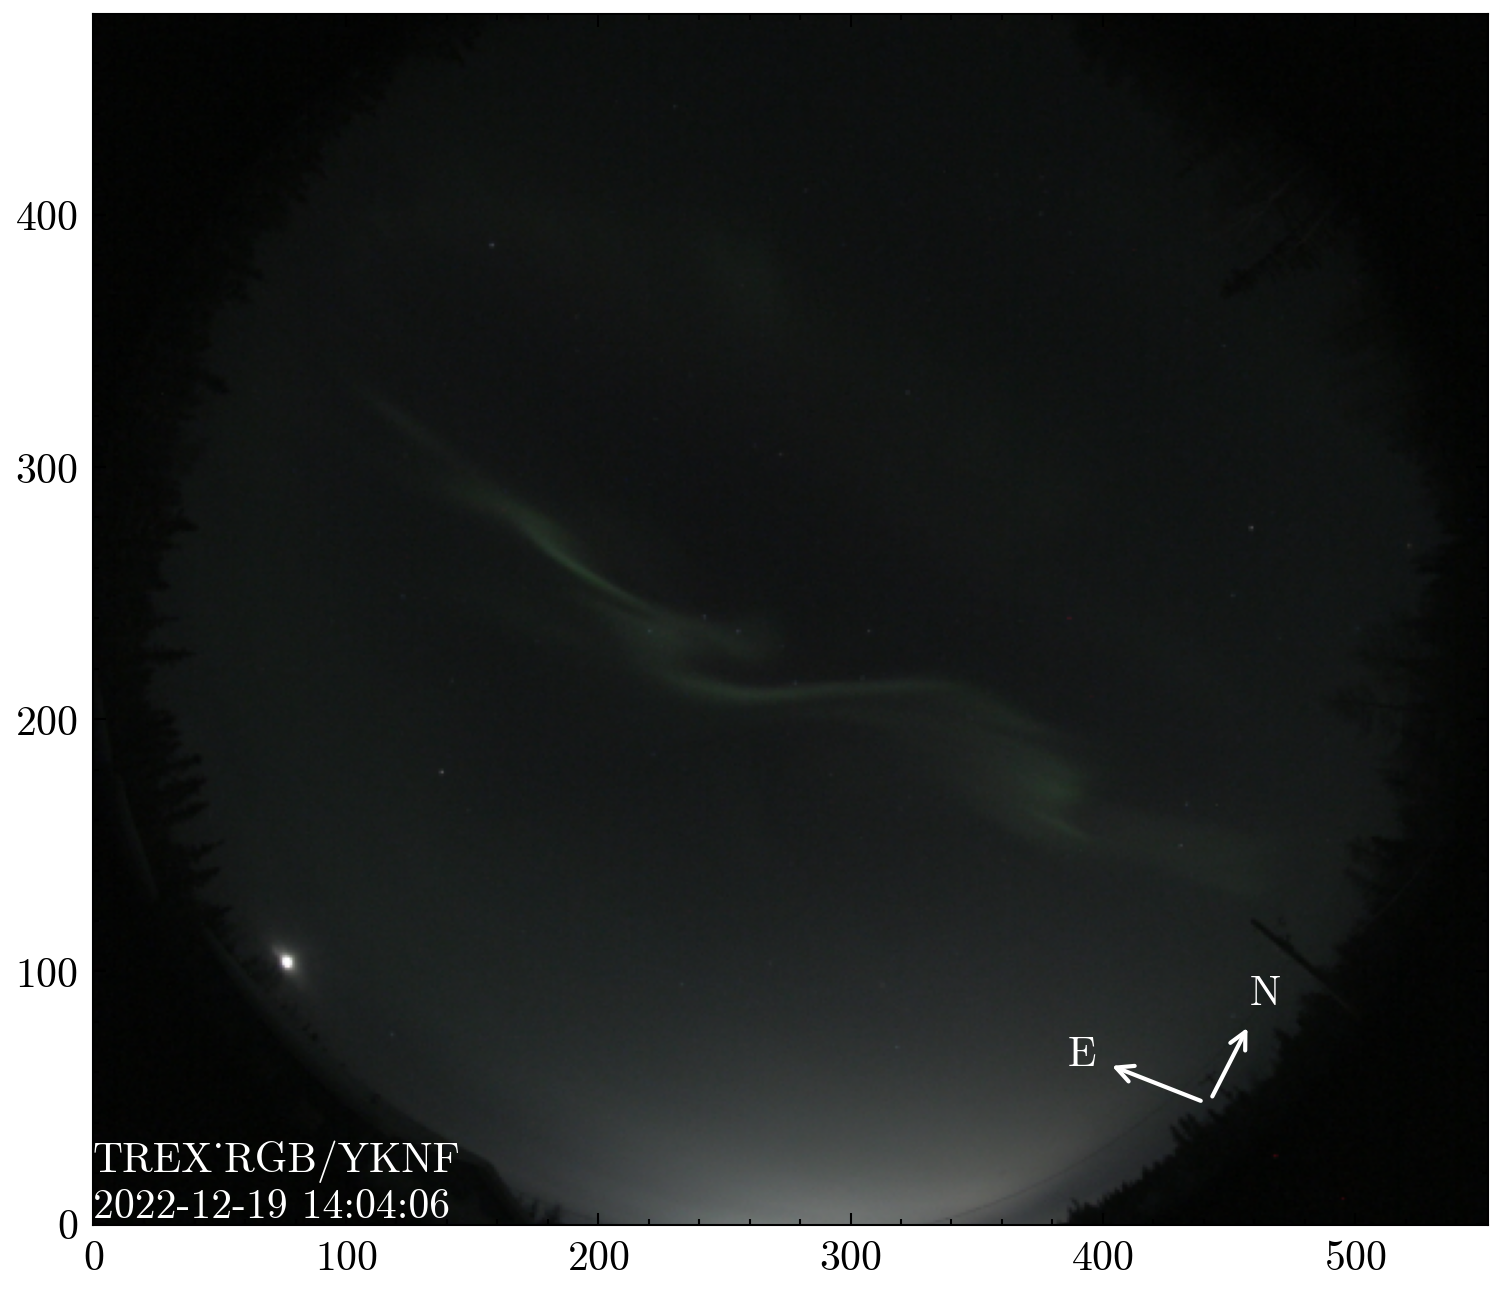

In [193]:
fig, ax = plt.subplots(figsize=(6,6), dpi=300)
asi_single=asilib.asi.trex_rgb(location_code='yknf', alt=110, time=datetime(2022,12,19,14,4,5), colors='rgb')

ax, im_good = asi_single.plot_fisheye(ax=ax)


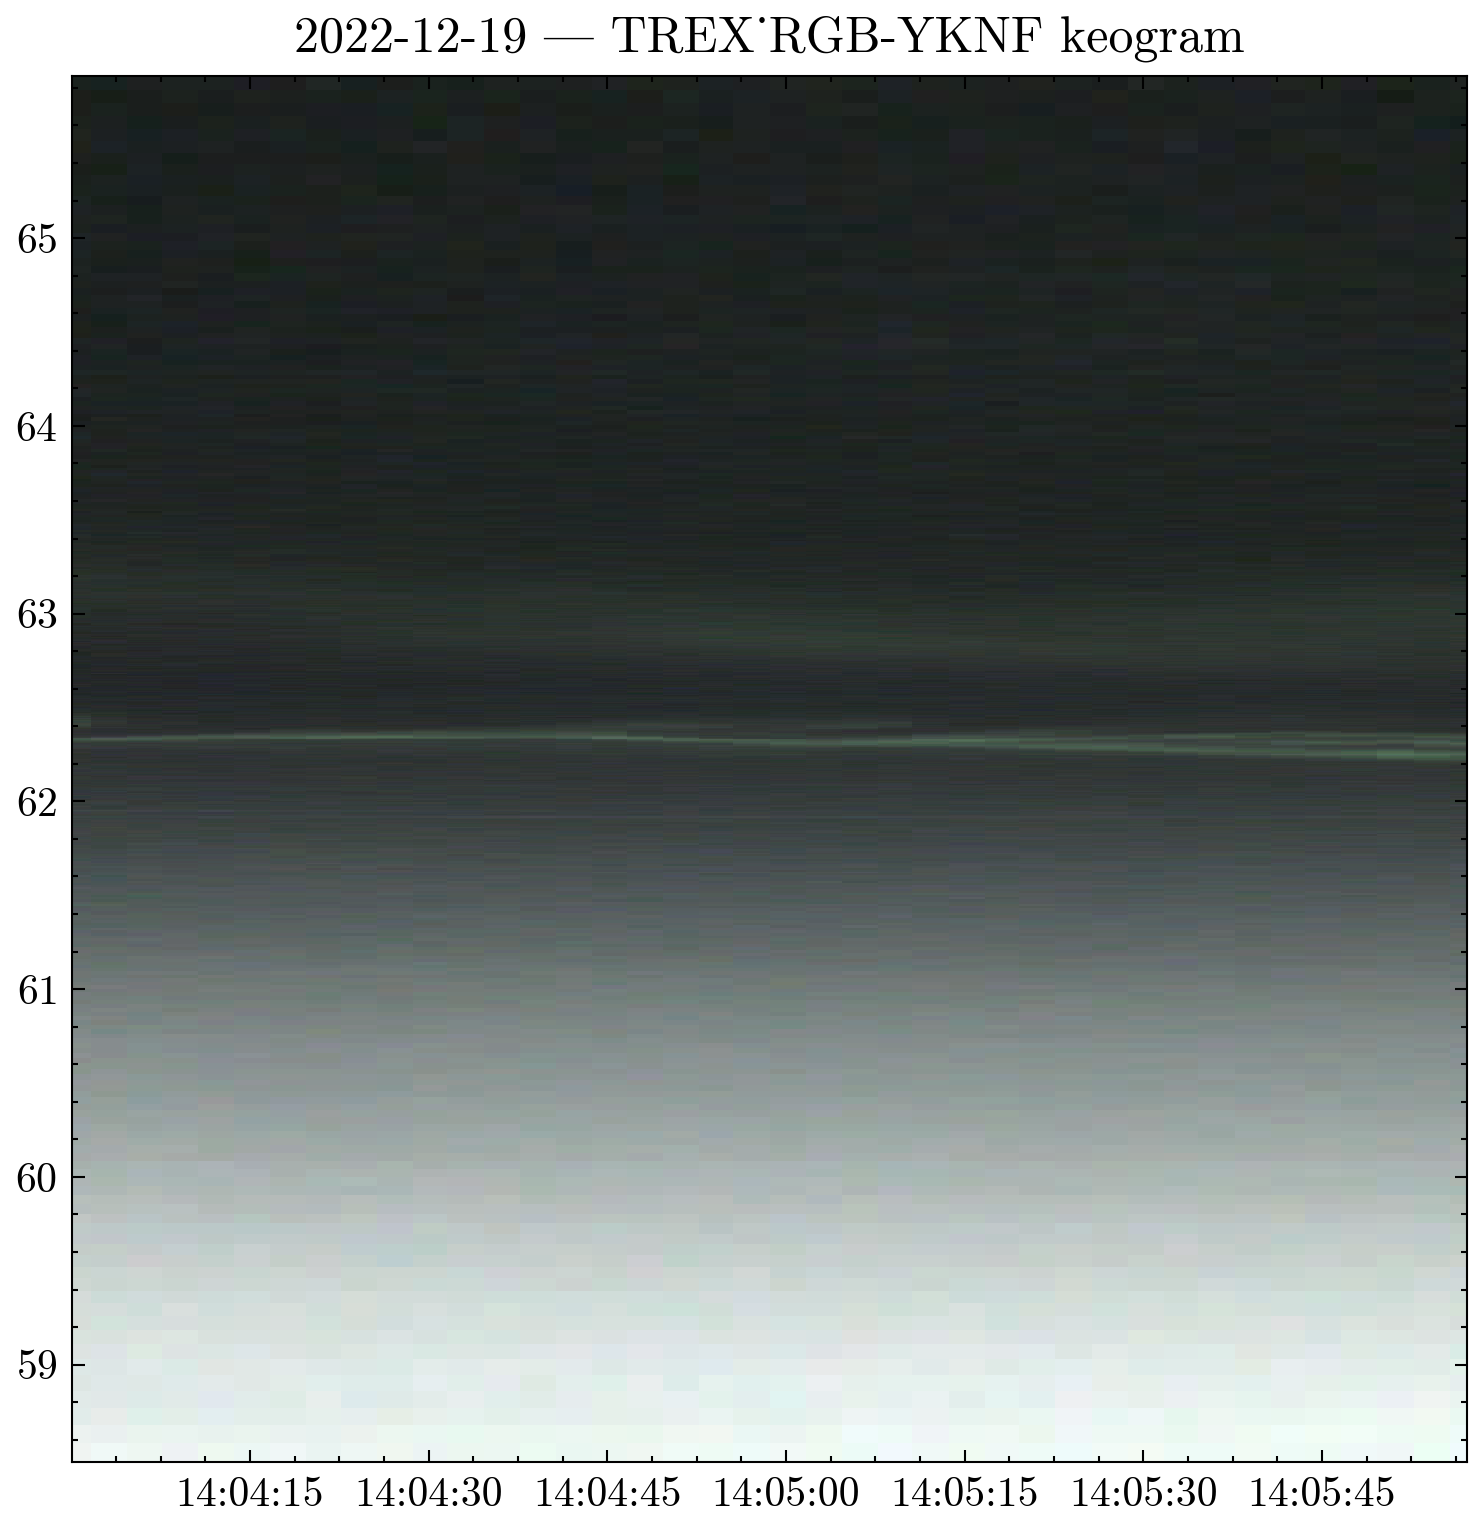

In [194]:
fig, axes = plt.subplots(figsize=(6,6), dpi=300)
axes,im = asi.plot_keogram(ax=axes)
x_data = im.get_coordinates()[:, 0, 1]
y_data = im.get_coordinates()[:, 1, 1]



(<Axes: title={'center': '2022-12-19 | TREX_RGB-YKNF keogram'}>,
 <matplotlib.collections.QuadMesh at 0x19dcb434f90>)

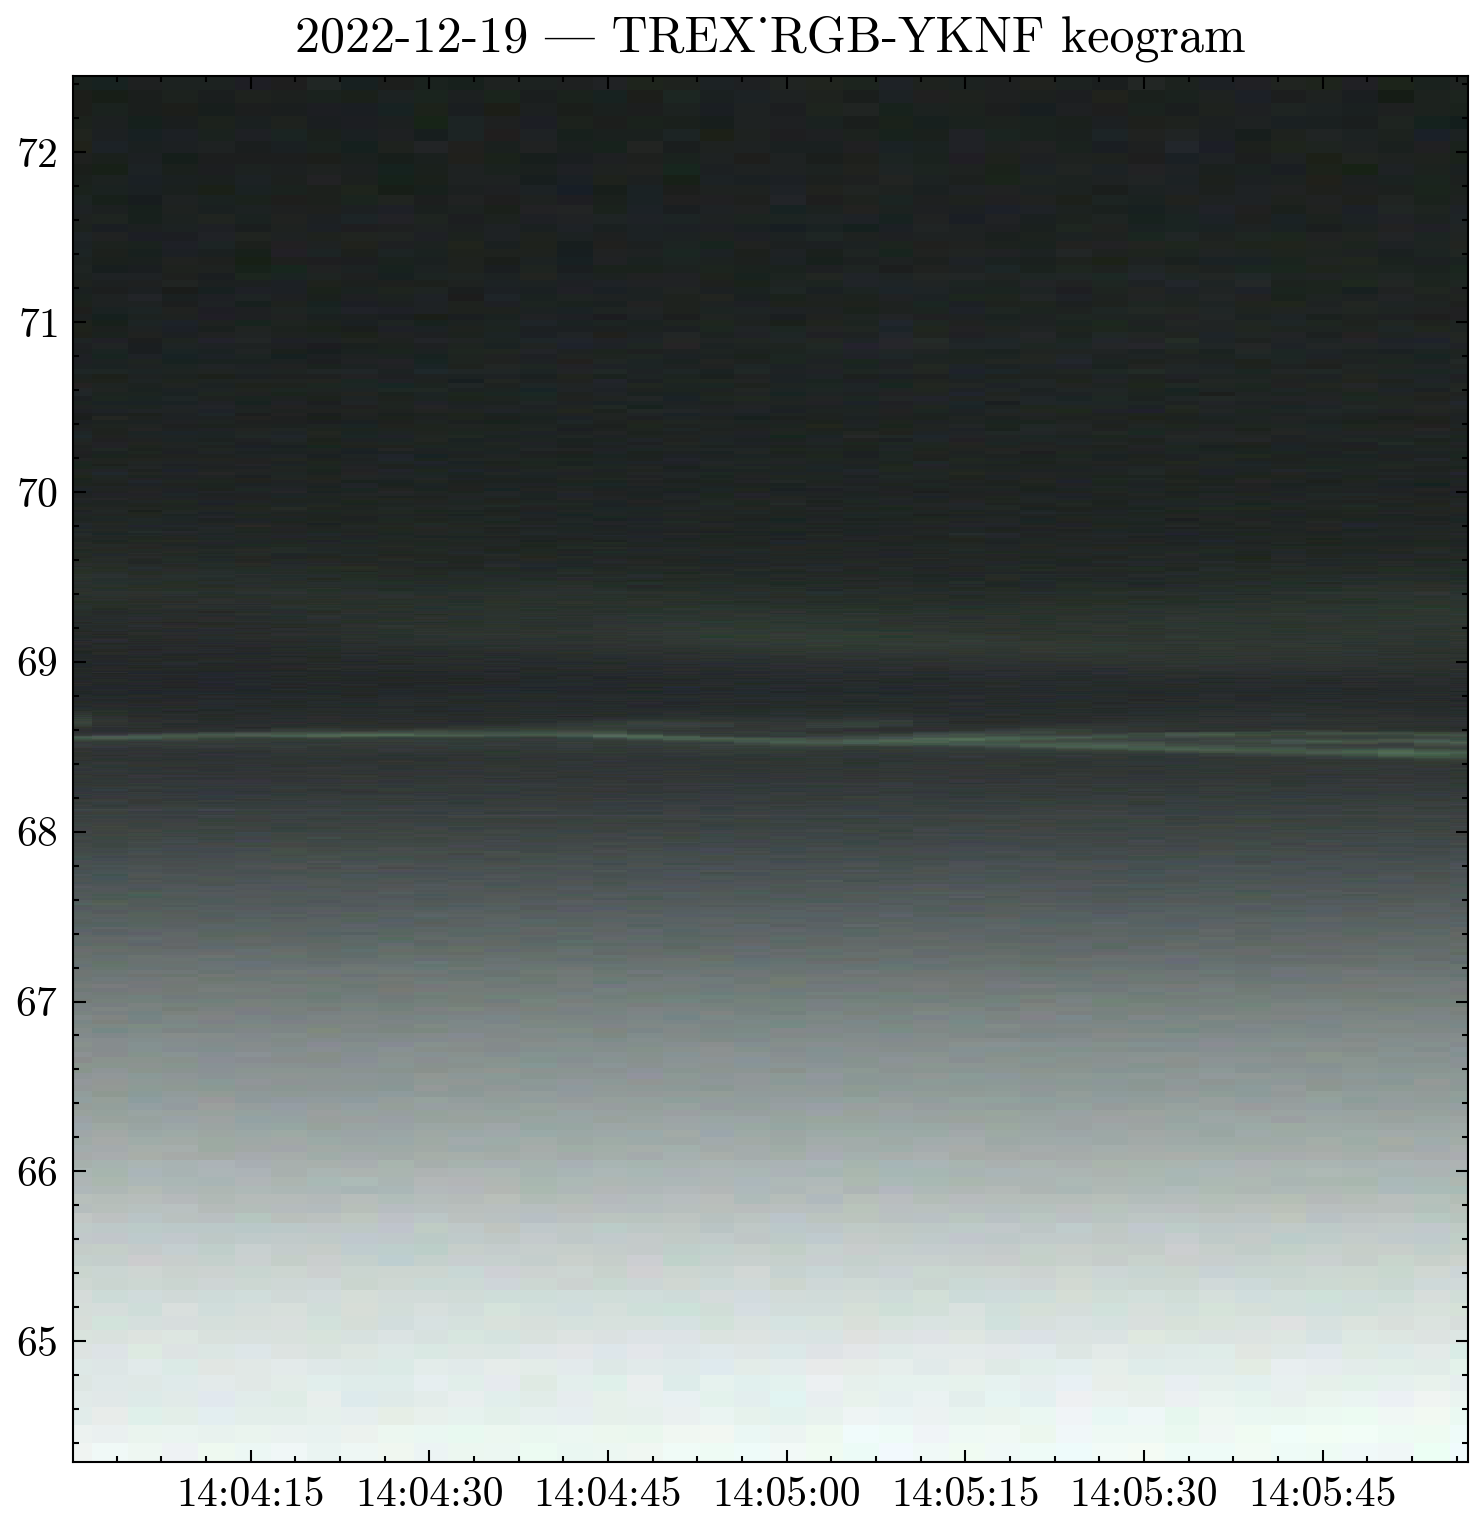

In [195]:
fig, axes = plt.subplots(figsize=(6,6), dpi=300)
axes,im = asi.plot_keogram(ax=axes)
x_data = im.get_coordinates()[:, 0, 1]
y_data = im.get_coordinates()[:, 1, 1]

Axes(0.125,0.11;0.775x0.77)
(479, 120, 3)
(480,)


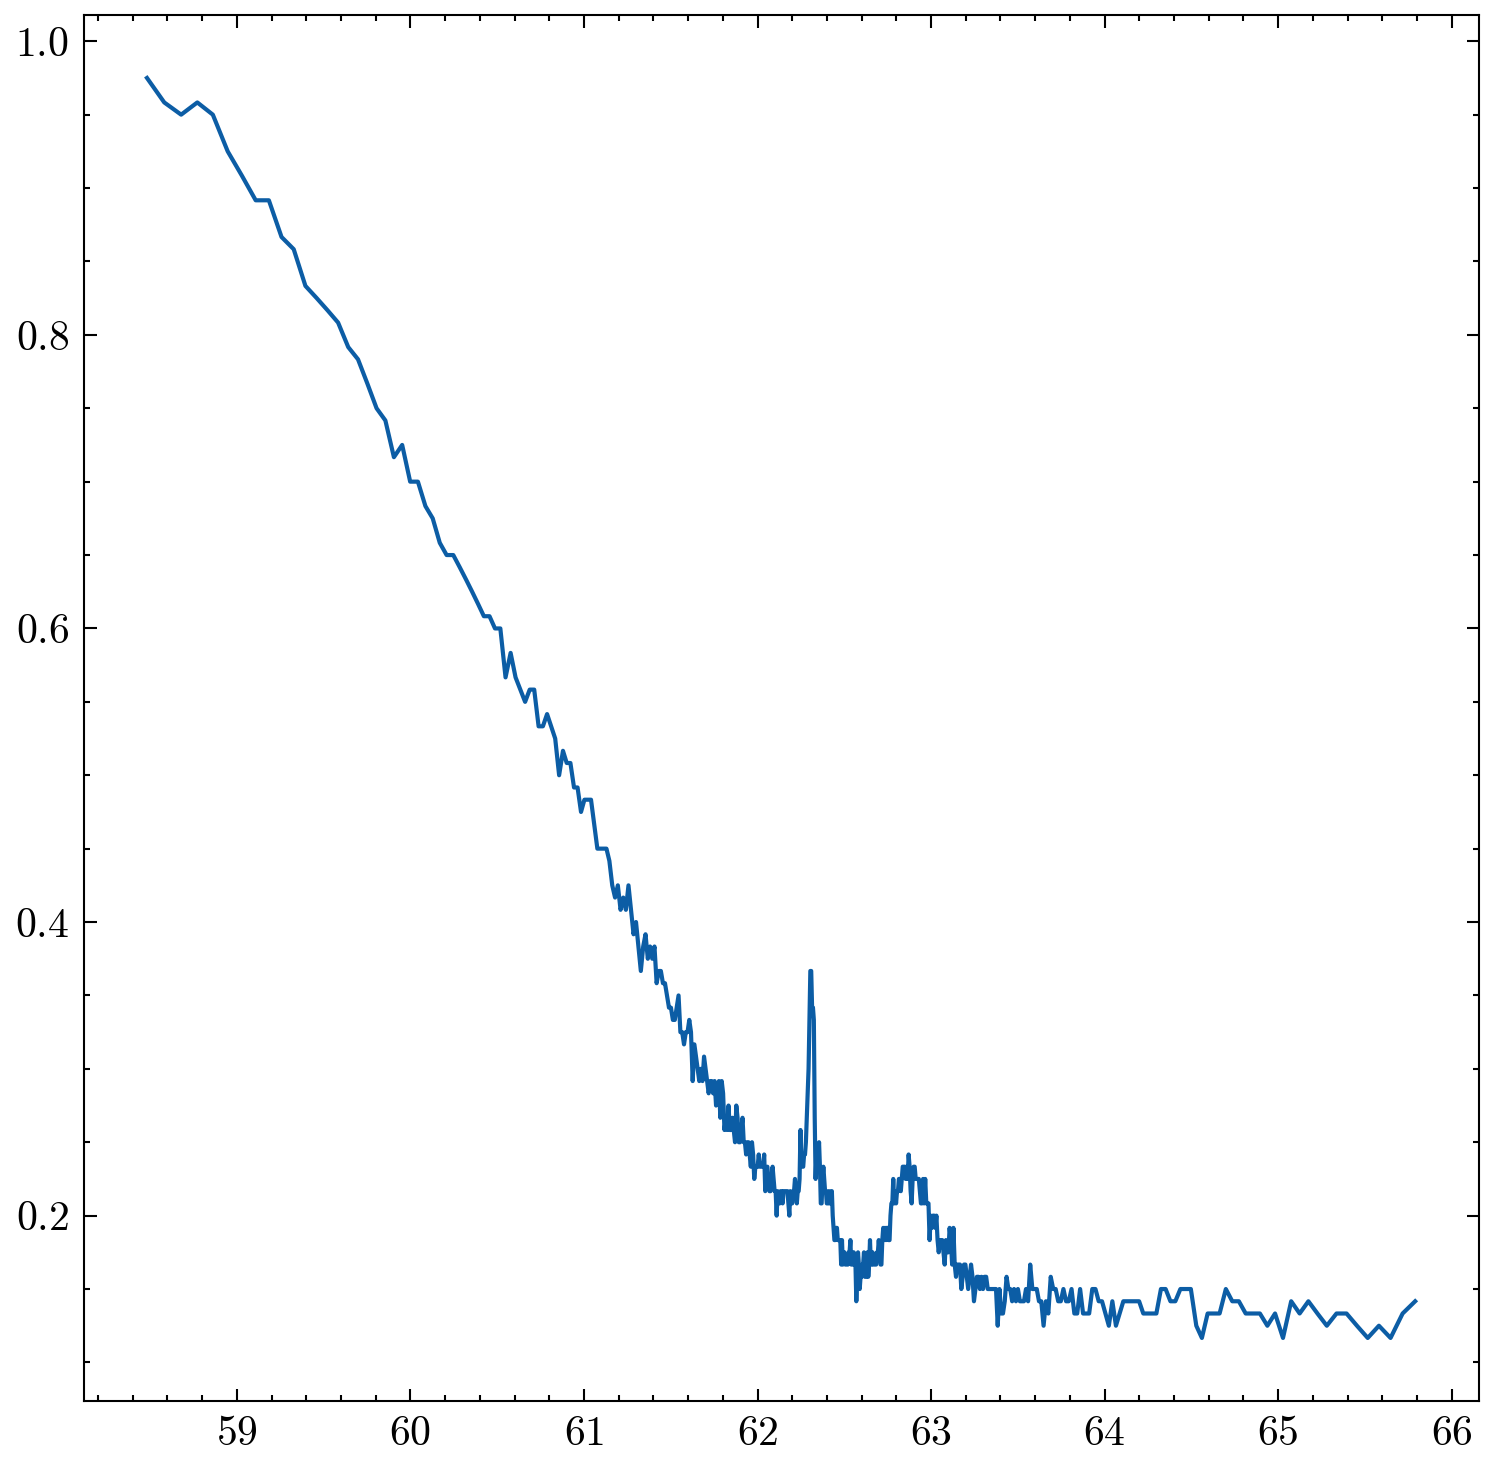

In [196]:
print(axes)
print(im)
print(np.shape(im.get_array()))
x_data = im.get_coordinates()[:, 0, 1]
y_data = im.get_coordinates()[:, 1, 1]
print(np.shape(x_data))
fig, axes = plt.subplots(figsize=(6,6), dpi=300)

plt.plot(im.get_coordinates()[:, 60, 1][:-1], im.get_array()[:, 60, 1])

In [201]:
import aacgmv2
lat16 = np.rad2deg(lat_sat_done_E)
lat50 = np.rad2deg(lat_sat_done_B)
lat16, _, _ = aacgmv2
lat50, _, _ = 
print(len(lat16))
print(len(lat50))

1920
6000


We want our plots to have lat verus data


(40, 3)


C:\Users\1101w\AppData\Local\Temp\ipykernel_19292\1069019302.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)


(59.0, 65.6)

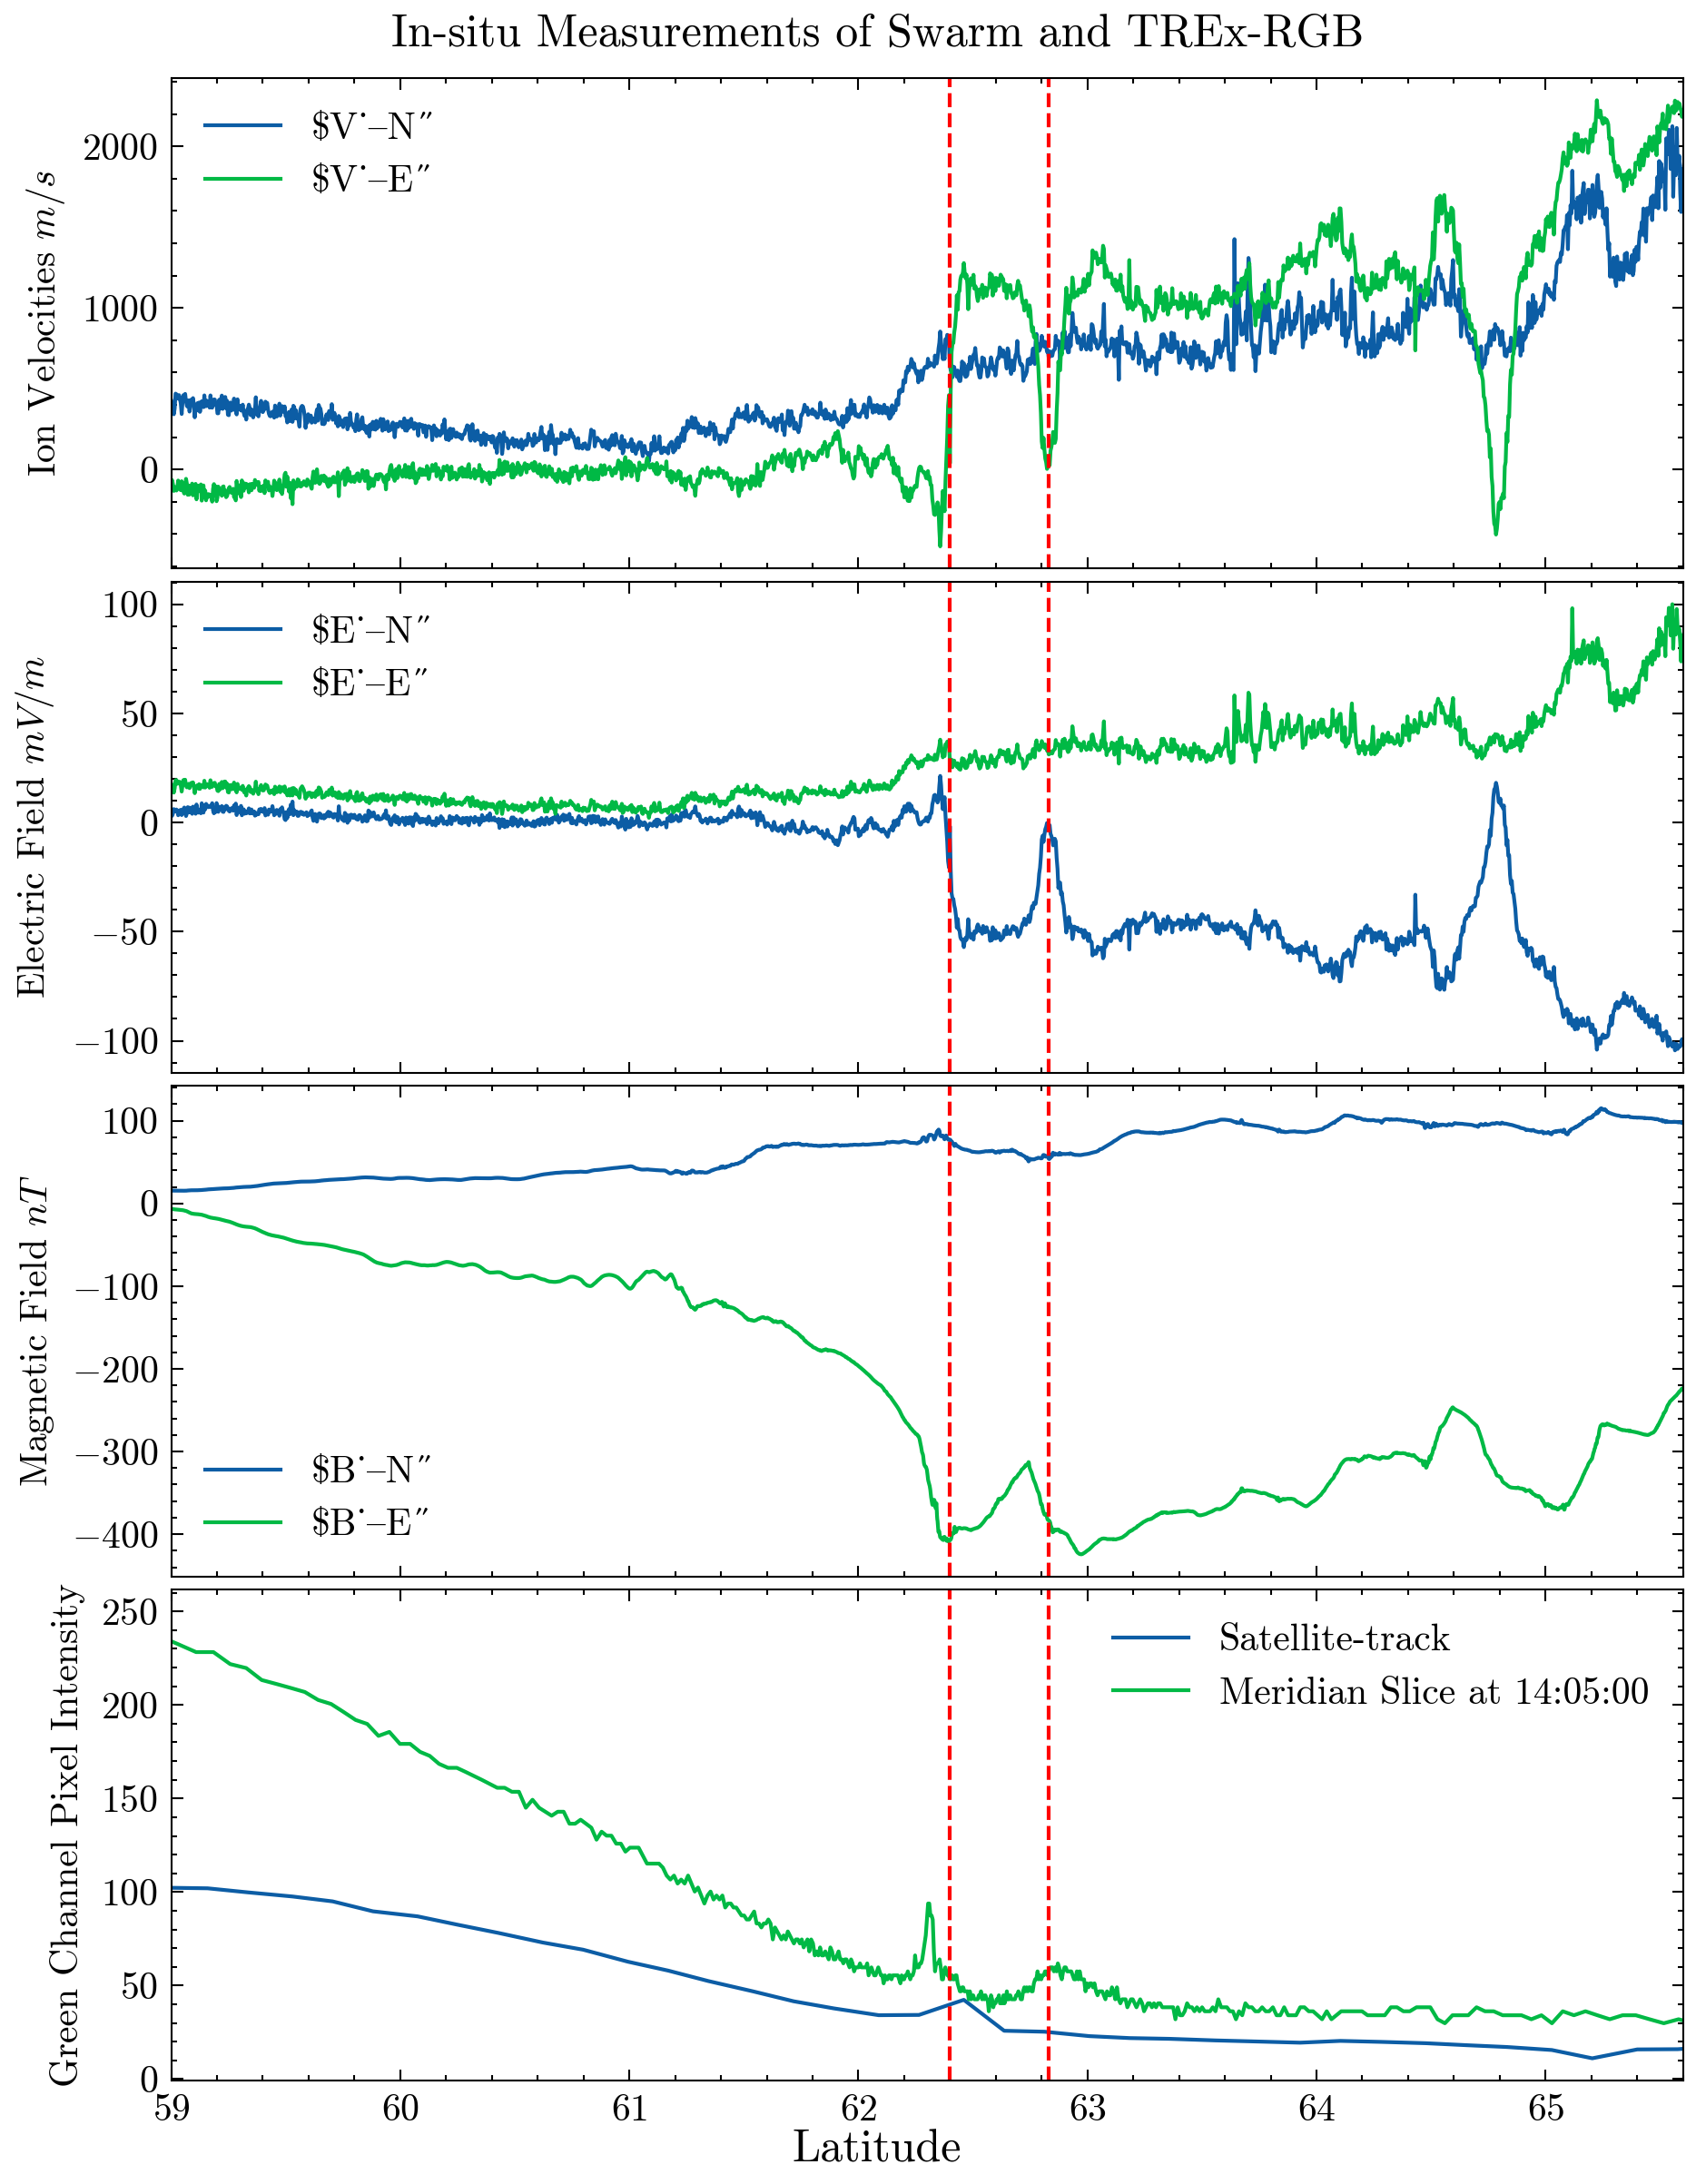

In [213]:
fig, axes = plt.subplots(figsize=(6,8), nrows=4, dpi=300, constrained_layout=True, sharex=True)
#We want B east and north, then E north and East and then the pixel intensity of the satellite and the pixel intensity of the keogram
axes[0].plot(lat16, VNEC[:,0], label=r"$V_{N}")
axes[0].plot(lat16, VNEC[:, 1], label=r"$V_{E}")
axes[1].plot(lat16, ENEC[:,0], label=r"$E_{N}")
axes[1].plot(lat16, ENEC[:, 1], label=r"$E_{E}")
axes[2].plot(lat50,BNEC[:,0], label=r"$B_{N}")
axes[2].plot(lat50, BNEC[:, 1], label=r"$B_{E}")
print(np.shape(area_intensity))
axes[3].plot(conjunction_obj.sat['lat'].T ,area_intensity[:,1], label="Satellite-track") #Change colors
axes[3].plot(im.get_coordinates()[:, 60, 1][:-1], im.get_array()[:, 60, 1]*256, label="Meridian Slice at 14:05:00") #change colors

axes[0].axvline(62.4, linestyle='dashed', color='red') #change color
axes[1].axvline(62.4, linestyle='dashed', color='red') #change color
axes[2].axvline(62.4, linestyle='dashed', color='red') #change color
axes[3].axvline(62.4, linestyle='dashed', color='red') #change color

axes[0].axvline(62.83, linestyle='dashed', color='red') #change color
axes[1].axvline(62.83, linestyle='dashed', color='red') #change color
axes[2].axvline(62.83, linestyle='dashed', color='red') #change color
axes[3].axvline(62.83, linestyle='dashed', color='red') #change color


plt.suptitle("In-situ Measurements of Swarm and TREx-RGB", y=1)
fig.supxlabel("Magnetic Latitude")

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
plt.tight_layout(pad=0.3, w_pad=0.6, h_pad=0.35)

axes[0].set_ylabel(r"Ion Velocities $m/s$")
axes[1].set_ylabel(r"Electric Field $mV/m$")
axes[2].set_ylabel(r"Magnetic Field $nT$")
axes[3].set_ylabel(r"Green Channel Pixel Intensity")

axes[0].set_xlim(59, 65.6)
axes[1].set_xlim(59, 65.6)
axes[2].set_xlim(59, 65.6)
axes[3].set_xlim(59, 65.6)